In [1]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
os.chdir("OriginalFromAllenDB")

In [3]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
from bmtool.synapses import SynapseTuner

In [4]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()

1.0

In [5]:
!nrnivmodl modfiles 

/home/dpd4k4/repos/binocular_integration/OriginalFromAllenDB
Mod files: "modfiles/modfiles/AMPA_NMDA_STP.mod" "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/NMDAIN.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/SK.mod" "modfiles/modfiles/cpampain.mod" "modfiles/modfiles/gabaain.mod" "modfiles/modfiles/vecstim.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [6]:
h.nrn_load_dll("modfiles/x86_64/.libs/libnrnmech.so")

0.0

In [7]:
import random
from neuron import h

class AllenCell:
    def __init__(self, gid, soma_diam_multiplier=1.0):
        
        self._gid = gid
        self.synapses = []  # Keep track of all synapses
        self.netcons = []   # Keep track of NetCons
        self.stims = []     # Keep VecStims so they don't get garbage-collected

        description = Config().load('manifest.json')

        self.utils = Utils(description)
        self.h = self.utils.h
        self.Vinit = self.utils.description.data['conditions'][0]['v_init']
        # Cast all genome values to float
        for d in self.utils.description.data['genome']:
            if 'value' in d:
                d['value'] = float(d['value'])

        # Load morphology and parameters
        morphology_path = description.manifest.get_path('MORPHOLOGY')
        self.utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
        self.utils.load_cell_parameters()
        self.setup_morphology(soma_diam_multiplier)
        self._build_section_list()
    
    def setup_morphology(self,soma_diam_multiplier):

        self.soma = self.h.soma
        self.h.soma[0].diam *= soma_diam_multiplier
        self.dend = list(self.h.dend) if hasattr(self.h, 'dend') else []
        self.apic = list(self.h.apic) if hasattr(self.h, 'apic') else []
        self.axon = list(self.h.axon) if hasattr(self.h, 'axon') else []


    def _build_section_list(self):
        self.all = h.SectionList()
        for sec in h.allsec():
            self.all.append(sec)
    
    def add_random_synapses_from_df(self, df, syn_name, syn_params, section_pool=None):
        """
        Adds synapses at random locations with input times from a DataFrame.

        Parameters:
        - df: DataFrame with 'node' and 'timestamps' columns
        - syn_name: string name of NMODL synapse mechanism
        - syn_params: dictionary of synapse parameters (e.g. gmax, tau, e)
        - section_pool: list of sections to randomly choose from (default = self.dend)
        """
        if section_pool is None:
            section_pool = self.dend  # Default to dendrites

        for _, row in df.iterrows():
            timestamps = row['timestamps']
            if not timestamps:
                continue

            sec = random.choice(section_pool)
            loc = random.uniform(0.1, 0.9)

            # Create synapse
            syn = getattr(h, syn_name)(sec(loc))
            for param, val in syn_params.items():
                if hasattr(syn, param):
                    setattr(syn, param, val)

            # Create VecStim with spike times
            vec = h.Vector(timestamps)
            stim = h.VecStim()
            stim.play(vec)
            self.stims.append(stim)

            nc = h.NetCon(stim, syn)
            nc.weight[0] = syn_params.get('weight', 0.001)

            self.synapses.append(syn)
            self.netcons.append(nc)


            
    def __str__(self):
        return f"AllenCell(soma={self.soma}, dendrites={len(self.dend)})"


In [8]:
cell = AllenCell(0)

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [9]:
syn_params =  {
            'initW': 3,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.13,
            'Dep': 0.,
            'Fac': 200.
        }

In [10]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
PFR = pd.read_csv(os.path.join("..","pyrFiringRateAvg.csv"),delimiter=",")

In [12]:


PFR_time_shortened = np.array(PFR['Time'][PFR['Time'] >0])
PFR_firing_rate_shortened = np.array(PFR['AvgFiringRate'][PFR['Time'] >0])
# plt.plot(PFR_time_shortened,PFR_firing_rate_shortened)
# plt.title("Average Pyramidal Firing Rate Shortened")
# plt.show()



In [13]:
num_neurons = 10000
psg = PoissonSpikeGenerator(population='example_pop', seed=32)

for i in range(num_neurons):
    psg.add(
        node_ids=i,
        firing_rate=PFR_firing_rate_shortened,
        times=PFR_time_shortened
    )

spikes_df = psg.to_dataframe()
print(f"Generated {len(spikes_df)} spikes across {num_neurons} neurons")

firing_rates = []
# Now loop over actual neuron IDs
for node_id in range(num_neurons):
    cell_spikes = spikes_df[spikes_df['node_ids'] == node_id]
    duration = PFR_time_shortened[-1] - PFR_time_shortened[0]
    firing_rate = len(cell_spikes) / duration
    firing_rates.append(firing_rate)
    # print(f"Neuron {node_id}: {len(cell_spikes)} spikes, mean rate = {firing_rate:.2f} Hz")

Generated 30051 spikes across 10000 neurons


In [14]:
N = 2  
df_sampled = spikes_df.sample(n=N, random_state=42)

In [15]:
cell.add_random_synapses_from_df(df_sampled, "AMPA_NMDA_STP", syn_params, section_pool=cell.dend)

In [16]:

print(f"Added {len(cell.synapses)} synapses")
for i, syn in enumerate(cell.synapses):
    print(f"Synapse {i}: {syn.get_segment().sec.name()} @ {syn.get_segment().x}")




Added 2 synapses
Synapse 0: dend[31] @ 0.5
Synapse 1: dend[28] @ 0.5


In [17]:
from neuron import h, gui  # gui not needed in headless scripts

# Set recording vectors
tvec = h.Vector().record(h._ref_t)
vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

# Simulation control
h.finitialize(cell.Vinit)
h.tstop = 100.0  # ms
h.run()


0.0

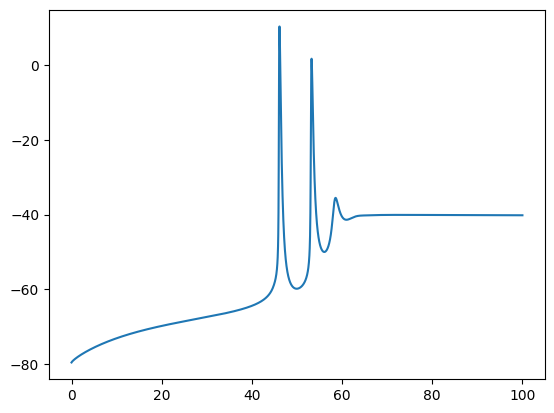

In [18]:
plt.plot(tvec,vvec)

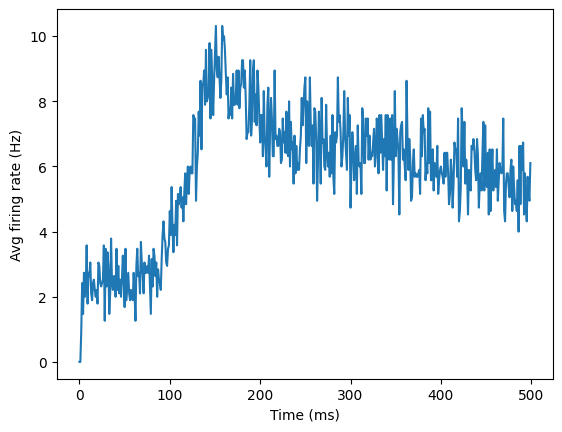

In [14]:


# Define time bins (assuming ms timestamps and 1 ms bins)
bin_size = 1  # in ms
times = np.arange(0, 500 + bin_size, bin_size)

# Histogram of spike counts per bin
spike_counts, _ = np.histogram(spikes_df['timestamps'], bins=times)

# Optional: Normalize to get firing rate
# If you have N neurons and you want average firing rate per neuron:
N_NEURONS = len(spikes_df['node_ids'].unique())
spike_rate = spike_counts / (bin_size / 1000) / N_NEURONS  # Convert ms to seconds

plt.plot(times[:-1], spike_rate)
plt.xlabel("Time (ms)")
plt.ylabel("Avg firing rate (Hz)")
plt.show()

